## **Пыльцин Илья ИАД-5**

# Imports

In [0]:
!pip install imgaug

    100% |████████████████████████████████| 634kB 19.8MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [0]:
import zipfile
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib.pyplot as plt
import io
import csv
import imgaug as ia
from imgaug import augmenters as iaa

# Download data from Kaggle

In [0]:
# we need to use python 3 version of Kaggle!
# remove python 2 version with `pip uninstall kaggle`
! pip3 install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.0)


In [0]:
# get <token> from https://www.kaggle.com/<user>/account, click "Create New API Token", open json file
! KAGGLE_USERNAME='ilya013' KAGGLE_KEY="ced00b4e905f4f0bbf7e175fa2033cf8" kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip --force

100% 7.37G/7.37G [01:58<00:00, 106MB/s] 
100% 7.37G/7.37G [01:58<00:00, 66.9MB/s]


In [0]:
# open zip file, will read everything from it
zf = zipfile.ZipFile("train_simplified.zip")

# Data generators from disk (no need to store in RAM)

In [0]:
class_form = zf.namelist()
class_labels = []

for i in class_form:
  class_labels.append(i.split('.')[0])

class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with io.TextIOWrapper(zf.open(fn)) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print (fn, "is done, starting from the beginning...")

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [next(gen) for gen in generators[random_indices]]

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import json

IMG_SIZE = 128

# faster conversion function
def draw_it(strs, gr=False):
     
    clr=255
    strs = json.loads(strs)
    image = Image.new("P", (256,256), color=0)
    image_draw = ImageDraw.Draw(image)
  
    for i in range(len(strs)):
      lines = strs[i]
      coord_list = []  
      
      for j in range(len(lines[1])):
          coord_list.append(lines[0][j])
          coord_list.append(lines[1][j])
          
      image_draw.line(coord_list,fill=clr, width=10)
      clr += -15
    image = image.resize((IMG_SIZE, IMG_SIZE))
    
    if gr == True:
      
      image_draw = ImageDraw.Draw(image)
      grid = 16
      for i in range(8):  

        image_draw.line([grid,0,grid,128],fill=255, width=1)
        image_draw.line([0,grid,128,grid],fill=255, width=1)

        grid += 16
    
    
    return np.array(image, dtype=np.uint8)

# Data Augmentation

В данном ноутбуке представлены различные виды аугментации данных. В дальнейшем при обучении нейросетей было выяснено, что обучение на аугментированных данных нужно сочетать с обучением на оригинальных данных для достижения более высокого результата оценки. Также, перед аугментацией стоит просмотреть сами данные, чтобы понять какую именно аугментацию следует использовать, а какую нет. Например, применение контрастов для изображений предназначено для цветных картинок, а мы имеем черно-белую.

In [0]:
seq = iaa.Sequential([
#       iaa.Affine(scale=(0.5, 1.5)),
#       iaa.Crop(percent=(0, 0.1)),
      iaa.CoarseDropout((0.1, 0.3), size_percent=(0.02, 0.25)),
      iaa.Fliplr(0.5),
      iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.25),
#       iaa.Affine(rotate=(-45, 45)),
#       iaa.PiecewiseAffine(scale=(0.01, 0.05)),
#       iaa.Affine(shear=(-16, 16)),
#       iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
        ], random_order=False)

Некоторые строки закомментированны, так как в процессе обучения я использовал разные виды аугментации, но если использовать сразу все, то скорость обучения значительно падает, поэтому при обучении постоянно вручную изменялись одни закомментированные строчки на другие.

In [0]:
def images_and_labels_generator(batch_size, aug=False, gr=False):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0],gr))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        if aug == True:
            rand_ind = np.random.choice(np.arange(batch_size), size=int(batch_size))
            batch_images[rand_ind] = seq.augment_images(batch_images[rand_ind])
        yield batch_images, batch_labels

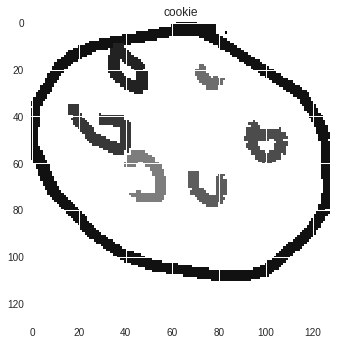

In [0]:
b = next(images_and_labels_generator(32))
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

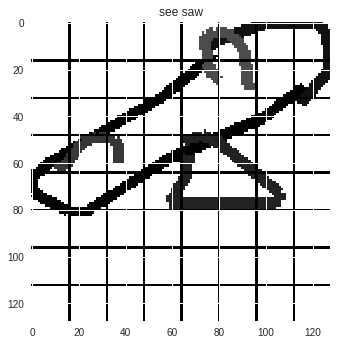

In [0]:
b = next(images_and_labels_generator(32, gr=True))
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

In [0]:
images = next(images_and_labels_generator(32))
image = (images[0][10,:,:]).reshape(1,IMG_SIZE, IMG_SIZE )
name_im = images[1][10]

In [0]:
aug_images = [image]

scale = lambda x: (iaa.Sequential([iaa.Affine(scale=(0.5, 1.5))])).augment_images(x)
crop = lambda x: iaa.Sequential([iaa.Crop(percent=(0, 0.1))]).augment_images(x)
coarse_dropout = lambda x: iaa.Sequential([iaa.CoarseDropout((0.1, 0.3), size_percent=(0.02, 0.25))]).augment_images(x)
rotate = lambda x: iaa.Sequential([iaa.Affine(rotate=(-100, 10))]).augment_images(x)
shear = lambda x: iaa.Sequential([iaa.Affine(shear=(-16, 16))]).augment_images(x)
flip = lambda x: iaa.Sequential([iaa.Fliplr(0.5)]).augment_images(x)
el_transform = lambda x: iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.25).augment_images(x)

for afunc in (scale, crop, coarse_dropout,rotate,shear,flip, el_transform):
    aug_images.append(afunc(image))

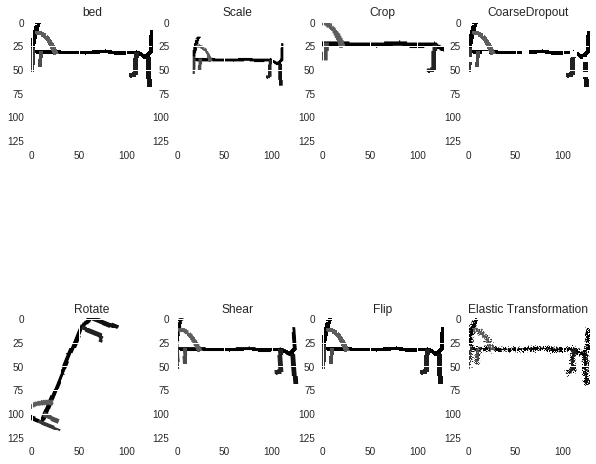

In [0]:
aug_list = [name_im,'Scale', 'Crop', 'CoarseDropout', 'Rotate', 'Shear', 'Flip', 'Elastic Transformation']

cols = 4
rows = 2
num = 0
fig = plt.figure(figsize=(10, 10))
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow((aug_images[num]).reshape(IMG_SIZE, IMG_SIZE ))
        ax.set_title(aug_list[num])
        num += 1
plt.show()

In [0]:
def images_and_labels_generator(batch_size, aug=False, gr=False):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0],gr))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        if aug == True:
            rand_ind = np.random.choice(np.arange(batch_size), size=int(batch_size))
            batch_images[rand_ind] = seq.augment_images(batch_images[rand_ind])
        yield batch_images, batch_labels

In [0]:
def apk(actual, predicted, k=3):
    
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
  
    actual = [[i] for i in np.argmax(actual,axis=1).tolist()]
    predicted = (np.argsort(-predicted)).tolist()
    
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

# Train simple network

In [0]:
import tensorflow as tf
import keras
from keras import backend as K

Using TensorFlow backend.


In [0]:
# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
list(class_to_idx.items())[:5]

[('fence', 0), ('yoga', 1), ('horse', 2), ('sandwich', 3), ('cat', 4)]

In [0]:
def train_iterator(batch_size, aug=False,gr=False):
    for batch in images_and_labels_generator(batch_size, aug, gr):
        images = batch[0].astype('float32')
        images = images / 255
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(list(map(class_to_idx.get, batch[1])), NUM_CLASSES)
        yield images, labels

In [0]:
sample = next(train_iterator(32))
print (sample[0].shape)
print (sample[1].shape)

(32, 128, 128, 1)
(32, 340)


# Model 1

In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU, ELU

In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    

    model.add(Conv2D(input_shape=[128, 128, 1], padding="SAME", kernel_size=[3,3], filters=16))
    model.add(LeakyReLU(0.1))
    
    model.add(MaxPooling2D(input_shape=[128, 128, 32], padding="SAME"))
    
    
    model.add(Conv2D(input_shape=[64, 64, 32], padding="SAME", kernel_size=[3,3], filters=32))
    model.add(LeakyReLU(0.1))
    
    model.add(MaxPooling2D(input_shape=[64, 64, 32], padding="SAME"))
    
    
    model.add(Conv2D(input_shape=[32, 32, 32], padding="SAME", kernel_size=[3,3], filters=64))
    model.add(LeakyReLU(0.1))
              
    model.add(MaxPooling2D(input_shape=[32, 32, 64], padding="SAME"))
    
    
    model.add(Flatten())
              
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    return model

In [0]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 350
STEPS_PER_EPOCH = 100
EPOCHS = 150

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 2
# model = load_model("model_{}".format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [0]:
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(BATCH_SIZE, aug=False), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=0
)

Epoch 1/150
100/100 [==============================] - 31s 311ms/step - loss: 2.7610 - categorical_accuracy: 0.3742 - top_3_accuracy: 0.5768
Model saved in model_0
Epoch 2/150
100/100 [==============================] - 31s 309ms/step - loss: 2.6977 - categorical_accuracy: 0.3915 - top_3_accuracy: 0.5923
Model saved in model_1
Epoch 3/150
100/100 [==============================] - 31s 309ms/step - loss: 2.6101 - categorical_accuracy: 0.4024 - top_3_accuracy: 0.6069
Model saved in model_2
Epoch 4/150
100/100 [==============================] - 31s 309ms/step - loss: 2.5261 - categorical_accuracy: 0.4214 - top_3_accuracy: 0.6239
Model saved in model_3
Epoch 5/150
100/100 [==============================] - 31s 311ms/step - loss: 2.4919 - categorical_accuracy: 0.4235 - top_3_accuracy: 0.6311
Model saved in model_4
Epoch 6/150
100/100 [==============================] - 31s 309ms/step - loss: 2.4901 - categorical_accuracy: 0.4337 - top_3_accuracy: 0.6319
Model saved in model_5
Epoch 7/150
100/

In [0]:
img, lbl = next(train_iterator(50000))
img_pred = model.predict_proba(img)
map3 = mapk(lbl, img_pred)
print('Map3: {:.3f}'.format(map3))

Map3: 0.727


In [0]:
model.fit_generator(
    train_iterator(64, aug=True), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=0
)

Epoch 1/150
100/100 [==============================] - 35s 352ms/step - loss: 5.1385 - categorical_accuracy: 0.0478 - top_3_accuracy: 0.1041
Model saved in model_0
Epoch 2/150
100/100 [==============================] - 35s 354ms/step - loss: 4.7978 - categorical_accuracy: 0.0711 - top_3_accuracy: 0.1534
Model saved in model_1
Epoch 3/150
100/100 [==============================] - 36s 355ms/step - loss: 4.5848 - categorical_accuracy: 0.0958 - top_3_accuracy: 0.1986
Model saved in model_2
Epoch 4/150
100/100 [==============================] - 36s 356ms/step - loss: 4.4269 - categorical_accuracy: 0.1134 - top_3_accuracy: 0.2270
Model saved in model_3
Epoch 5/150
100/100 [==============================] - 36s 356ms/step - loss: 4.2390 - categorical_accuracy: 0.1364 - top_3_accuracy: 0.2627
Model saved in model_4
Epoch 6/150
100/100 [==============================] - 36s 355ms/step - loss: 4.0987 - categorical_accuracy: 0.1542 - top_3_accuracy: 0.2983
Model saved in model_5
Epoch 7/150
100/

In [0]:
img, lbl = next(train_iterator(50000))
img_pred = model.predict_proba(img)
map3 = mapk(lbl, img_pred)
print('Map3: {:.3f}'.format(map3))

Map3: 0.606


# Model 2 

In [0]:
from keras.layers import AveragePooling2D

def make_model2():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    

    model.add(Conv2D(input_shape=[128, 128, 1], padding="SAME", kernel_size=[3,3], filters=1))
    model.add(LeakyReLU(0.9))

    
    model.add(Conv2D(input_shape=[128, 128, 2], padding="SAME", kernel_size=[3,3], filters=2))
    model.add(LeakyReLU(0.9))

    model.add(Conv2D(input_shape=[128, 128, 4], padding="SAME", kernel_size=[3,3], filters=4))
    model.add(LeakyReLU(0.9))
    
    model.add(MaxPooling2D(input_shape=[128, 128, 4], padding="SAME"))
    
    model.add((Dropout(0.25)))
    
    
    model.add(Conv2D(input_shape=[64, 64, 4], padding="SAME", kernel_size=[3,3], filters=8))
    model.add(LeakyReLU(0.9))

    
    model.add(Conv2D(input_shape=[64, 64, 8], padding="SAME", kernel_size=[3,3], filters=16))
    model.add(LeakyReLU(0.9))
    
    model.add(MaxPooling2D(input_shape=[64, 64, 16], padding="SAME"))

    model.add((Dropout(0.25)))

    
    
    model.add(Conv2D(input_shape=[32, 32, 16], padding="SAME", kernel_size=[3,3], filters=32))
    
    model.add(LeakyReLU(0.9))

    model.add(Conv2D(input_shape=[32, 32, 32], padding="SAME", kernel_size=[3,3], filters=64))
    model.add(LeakyReLU(0.9))
              
    model.add(MaxPooling2D(input_shape=[32, 32, 64], padding="SAME"))
    
    model.add((Dropout(0.25)))
    
    model.add(Conv2D(input_shape=[16, 16, 64], padding="SAME", kernel_size=[3,3], filters=64))
    model.add(LeakyReLU(0.9))
              
    model.add(MaxPooling2D(input_shape=[16, 16, 64], padding="SAME"))
    
    model.add((Dropout(0.25)))
    
    
    model.add(Flatten())
              
    model.add(Dense(4096))
    model.add(LeakyReLU(0.9))
    
    
    model.add(Dropout(0.5))
    
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    return model

In [0]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model2()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 1)       10        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 2)       20        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 2)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 4)       76        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128, 128, 4)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 4)         0         
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = 100
EPOCHS = 200

s = reset_tf_session()  # clear default graph
model = make_model2()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-8),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
last_finished_epoch = 0

#you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 2
# model = load_model("model_{}".format(last_finished_epoch), 
#                    custom_objects=)

In [0]:

BATCH_SIZE = 100
STEPS_PER_EPOCH = 100
EPOCHS = 100
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(BATCH_SIZE, aug=False), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=150,
     callbacks=[ModelSaveCallback("model_{}")]         ,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/150
100/100 [==============================] - 18s 178ms/step - loss: 5.2321 - categorical_accuracy: 0.0523 - top_3_accuracy: 0.1070
Model saved in model_0
Epoch 2/150
100/100 [==============================] - 14s 136ms/step - loss: 4.3186 - categorical_accuracy: 0.1491 - top_3_accuracy: 0.2719
Model saved in model_1
Epoch 3/150
100/100 [==============================] - 14s 136ms/step - loss: 3.8991 - categorical_accuracy: 0.2090 - top_3_accuracy: 0.3586
Model saved in model_2
Epoch 4/150
100/100 [==============================] - 14s 136ms/step - loss: 3.6752 - categorical_accuracy: 0.2394 - top_3_accuracy: 0.4025
Model saved in model_3
Epoch 5/150
100/100 [==============================] - 14s 136ms/step - loss: 3.5232 - categorical_accuracy: 0.2672 - top_3_accuracy: 0.4355
Model saved in model_4
Epoch 6/150
100/100 [==============================] - 14s 136ms/step - loss: 3.4508 - categorical_accuracy: 0.2830 - top_3_accuracy: 0.4548
Model saved in model_5
Epoch 7/150
100/

In [0]:
img, lbl = next(train_iterator(50000))
img_pred = model.predict_proba(img)
map3 = mapk(lbl, img_pred)
print('Map3: {:.3f}'.format(map3))

Map3: 0.546


In [0]:
model.fit_generator(
    train_iterator(32, aug=True), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=0
)

Epoch 1/100
100/100 [==============================] - 19s 191ms/step - loss: 3.5590 - categorical_accuracy: 0.2725 - top_3_accuracy: 0.4344
Model saved in model_0
Epoch 2/100
100/100 [==============================] - 19s 189ms/step - loss: 3.5997 - categorical_accuracy: 0.2697 - top_3_accuracy: 0.4284
Model saved in model_1
Epoch 3/100
100/100 [==============================] - 19s 193ms/step - loss: 3.5825 - categorical_accuracy: 0.2653 - top_3_accuracy: 0.4259
Model saved in model_2
Epoch 4/100
100/100 [==============================] - 19s 193ms/step - loss: 3.5533 - categorical_accuracy: 0.2606 - top_3_accuracy: 0.4387
Model saved in model_3
Epoch 5/100
100/100 [==============================] - 19s 193ms/step - loss: 3.7435 - categorical_accuracy: 0.2450 - top_3_accuracy: 0.3991
Model saved in model_4
Epoch 6/100
100/100 [==============================] - 19s 195ms/step - loss: 3.7504 - categorical_accuracy: 0.2441 - top_3_accuracy: 0.3994
Model saved in model_5
Epoch 7/100
100/

In [0]:
img, lbl = next(train_iterator(50000))
img_pred = model.predict_proba(img)
map3 = mapk(lbl, img_pred)
print('Map3: {:.3f}'.format(map3))

Map3: 0.477


# Model 3

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.activations import relu

In [0]:
from keras.layers import AveragePooling2D

def make_model3():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    

    model.add(Conv2D(input_shape=[128, 128, 1], padding="SAME", kernel_size=[3,3], filters=1))
    model.add(LeakyReLU())

    
    model.add(Conv2D(input_shape=[128, 128, 2], padding="SAME", kernel_size=[3,3], filters=2))
    model.add(LeakyReLU())

    model.add(Conv2D(input_shape=[128, 128, 4], padding="SAME", kernel_size=[3,3], filters=4))
    model.add(LeakyReLU())
    
    model.add(MaxPooling2D(input_shape=[128, 128, 4], padding="SAME"))
    
    model.add((Dropout(0.15)))
    
    
    model.add(Conv2D(input_shape=[64, 64, 4], padding="SAME", kernel_size=[3,3], filters=8))
    model.add(LeakyReLU())

    
    model.add(Conv2D(input_shape=[64, 64, 8], padding="SAME", kernel_size=[3,3], filters=16))
    model.add(LeakyReLU())
    
    model.add(MaxPooling2D(input_shape=[64, 64, 16], padding="SAME"))

    model.add((Dropout(0.15)))

    
    
    model.add(Conv2D(input_shape=[32, 32, 16], padding="SAME", kernel_size=[3,3], filters=32))
    
    model.add(LeakyReLU())

    model.add(Conv2D(input_shape=[32, 32, 32], padding="SAME", kernel_size=[3,3], filters=64))
    model.add(LeakyReLU())
              
    model.add(MaxPooling2D(input_shape=[32, 32, 64], padding="SAME"))
    
    model.add((Dropout(0.15)))
    
    model.add(Conv2D(input_shape=[16, 16, 64], padding="SAME", kernel_size=[3,3], filters=128))
    model.add(LeakyReLU())
              
    model.add(MaxPooling2D(input_shape=[16, 16, 64], padding="SAME"))
    
    model.add((Dropout(0.15)))
    
    
    model.add(Flatten())
              
    model.add(Dense(3048))
    model.add(LeakyReLU())
    
    model.add(BatchNormalization())
    
    
    model.add(Dense(3048))
    model.add(LeakyReLU())
    
    model.add(Dropout(0.5))
    
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    return model

In [0]:

# describe model
s = reset_tf_session()  # clear default graph
model = make_model3()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 1)       10        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 2)       20        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 2)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 4)       76        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128, 128, 4)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 4)         0         
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:

BATCH_SIZE = 100
STEPS_PER_EPOCH = 200
EPOCHS = 150
INIT_LR = 0.001
s = reset_tf_session()  # clear default graph
model = make_model3()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-5, decay=1e-5, amsgrad=False),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
last_finished_epoch = 0

#you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 380
# model = load_model("model_{}".format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [0]:
from keras.models import load_model
model = load_model("model_0815", 
                   custom_objects={"top_3_accuracy": top_3_accuracy})

In [0]:
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(150,gr=True), 
    steps_per_epoch=100,
    epochs=100,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=0
)

Epoch 1/100
100/100 [==============================] - 23s 225ms/step - loss: 1.2794 - categorical_accuracy: 0.6821 - top_3_accuracy: 0.8503
Model saved in model_0
Epoch 2/100
100/100 [==============================] - 20s 205ms/step - loss: 1.2753 - categorical_accuracy: 0.6833 - top_3_accuracy: 0.8504
Model saved in model_1
Epoch 3/100
100/100 [==============================] - 21s 205ms/step - loss: 1.2741 - categorical_accuracy: 0.6887 - top_3_accuracy: 0.8507
Model saved in model_2
Epoch 4/100
100/100 [==============================] - 20s 205ms/step - loss: 1.2816 - categorical_accuracy: 0.6843 - top_3_accuracy: 0.8473
Model saved in model_3
Epoch 5/100
100/100 [==============================] - 20s 205ms/step - loss: 1.2791 - categorical_accuracy: 0.6893 - top_3_accuracy: 0.8541
Model saved in model_4
Epoch 6/100
100/100 [==============================] - 21s 205ms/step - loss: 1.2735 - categorical_accuracy: 0.6861 - top_3_accuracy: 0.8517
Model saved in model_5
Epoch 7/100
100/

In [0]:
img, lbl = next(train_iterator(50000,gr=True))
img_pred = model.predict_proba(img)
map3 = mapk(lbl, img_pred)
print('Map3: {:.3f}'.format(map3))
del img_pred
del img
del lbl

Map3: 0.809


*результат может отличаться от значения на Kaggle, так как модель обучалась длительное время и была восстановлена не из самой последней эпохи (runtime обрывался)

In [0]:
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(64, aug=True), 
    steps_per_epoch=100,
    epochs=50,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=0
)

Epoch 1/50
100/100 [==============================] - 37s 368ms/step - loss: 2.2755 - categorical_accuracy: 0.4862 - top_3_accuracy: 0.6672
Model saved in model_0
Epoch 2/50
100/100 [==============================] - 36s 363ms/step - loss: 1.9821 - categorical_accuracy: 0.5266 - top_3_accuracy: 0.7219
Model saved in model_1
Epoch 3/50
100/100 [==============================] - 36s 361ms/step - loss: 1.9718 - categorical_accuracy: 0.5308 - top_3_accuracy: 0.7206
Model saved in model_2
Epoch 4/50
100/100 [==============================] - 36s 365ms/step - loss: 1.8743 - categorical_accuracy: 0.5537 - top_3_accuracy: 0.7416
Model saved in model_3
Epoch 5/50
100/100 [==============================] - 37s 365ms/step - loss: 1.8316 - categorical_accuracy: 0.5603 - top_3_accuracy: 0.7464
Model saved in model_4
Epoch 6/50
100/100 [==============================] - 37s 366ms/step - loss: 1.8486 - categorical_accuracy: 0.5519 - top_3_accuracy: 0.7522
Model saved in model_5
Epoch 7/50
100/100 [==

In [0]:
model.fit_generator(
    train_iterator(150,gr=True), 
    steps_per_epoch=100,
    epochs=25,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=0
)

Epoch 1/25
100/100 [==============================] - 21s 206ms/step - loss: 1.3666 - categorical_accuracy: 0.6656 - top_3_accuracy: 0.8324
Model saved in model_0
Epoch 2/25
100/100 [==============================] - 21s 205ms/step - loss: 1.2087 - categorical_accuracy: 0.6998 - top_3_accuracy: 0.8609
Model saved in model_1
Epoch 3/25
100/100 [==============================] - 21s 206ms/step - loss: 1.2048 - categorical_accuracy: 0.6981 - top_3_accuracy: 0.8625
Model saved in model_2
Epoch 4/25
100/100 [==============================] - 21s 206ms/step - loss: 1.2190 - categorical_accuracy: 0.7008 - top_3_accuracy: 0.8577
Model saved in model_3
Epoch 5/25
100/100 [==============================] - 21s 205ms/step - loss: 1.1903 - categorical_accuracy: 0.7045 - top_3_accuracy: 0.8633
Model saved in model_4
Epoch 6/25
100/100 [==============================] - 21s 205ms/step - loss: 1.1507 - categorical_accuracy: 0.7120 - top_3_accuracy: 0.8685
Model saved in model_5
Epoch 7/25
100/100 [==

In [0]:
img, lbl = next(train_iterator(50000))
img_pred = model.predict_proba(img)
map3 = mapk(lbl, img_pred)
print('Map3: {:.3f}'.format(map3))
del img_pred
del img
del lbl

Map3: 0.817


Данная модель представляет лучшее качество, чем все предыдущие, так как с одной стороны более глубокая, а с другой стороны требует меньше времени для обучения, чем следующие модели.

# Model 4

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.activations import relu

In [0]:
from keras.layers import AveragePooling2D

def make_model4():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    

    model.add(Conv2D(input_shape=[64, 64, 1], padding="SAME", kernel_size=[5,5], filters=64, strides=(2,2)))
    model.add(LeakyReLU(0.5))    
    
    model.add(MaxPooling2D(input_shape=[64, 64, 16], padding="SAME", strides=(2,2)))

    
    model.add(Conv2D(input_shape=[32,32, 128], padding="SAME", kernel_size=[4,4], filters=128, strides=(2,2)))
    model.add(LeakyReLU(0.5))    
    
    model.add(MaxPooling2D(input_shape=[32, 32, 48], padding="SAME", strides=(2,2)))
    
    model.add(Dropout(0.15))
    
    model.add(Conv2D(input_shape=[16, 16, 48], padding="SAME", kernel_size=[3,3], filters=256))
    model.add(LeakyReLU(0.5))    
    
    model.add(MaxPooling2D(input_shape=[16, 16, 90], padding="SAME", strides=(2,2)))
    
    model.add(Dropout(0.15))
    
    
    model.add(Flatten())
              
    model.add(Dense(9192))
    model.add(LeakyReLU(0.5))    
    
    model.add(Dense(4096))
    model.add(LeakyReLU(0.5))
    
    
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    return model

In [0]:

# describe model
s = reset_tf_session()  # clear default graph
model = make_model4()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 128)         0         
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:

BATCH_SIZE = 200
STEPS_PER_EPOCH = 100
EPOCHS = 100000
INIT_LR = 0.001
s = reset_tf_session()  # clear default graph
model = make_model4()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1e-4),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
last_finished_epoch = 0

#you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 380
# model = load_model("model_{}".format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [0]:
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(20, aug=False), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/100000
100/100 [==============================] - 6s 64ms/step - loss: 1.0920 - categorical_accuracy: 0.7305 - top_3_accuracy: 0.8795
Model saved in model_0
Epoch 2/100000
 14/100 [===>..........................] - ETA: 5s - loss: 1.4288 - categorical_accuracy: 0.6429 - top_3_accuracy: 0.8214

KeyboardInterrupt: ignored

# Model 5

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization 
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.activations import relu

In [0]:
from keras.layers import AveragePooling2D

def make_model5():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    

    model.add(Conv2D(input_shape=[64, 64, 1], padding="SAME", kernel_size=[6,6], filters=32, strides=(2,2)))
    model.add(LeakyReLU(0.9))    
    
    model.add(MaxPooling2D(input_shape=[64, 64, 32], padding="SAME", strides=(2,2)))
    
    
    model.add(Conv2D(input_shape=[32,32, 32], padding="SAME", kernel_size=[5,5], filters=64, strides=(2,2)))
    model.add(LeakyReLU(0.9))    
    
    model.add(MaxPooling2D(input_shape=[32, 32, 64], padding="SAME", strides=(2,2)))
    

    
    model.add(Dropout(0.1))
    
    model.add(Conv2D(input_shape=[16, 16, 64], padding="SAME", kernel_size=[3,3], filters=128))
    model.add(LeakyReLU(0.9))    
    
    model.add(MaxPooling2D(input_shape=[16, 16, 128], padding="SAME", strides=(2,2)))
    
    model.add(Conv2D(input_shape=[8, 8, 128], padding="SAME", kernel_size=[6,6], filters=256, strides=(2,2)))
    model.add(LeakyReLU(0.9))    
    
    model.add(MaxPooling2D(input_shape=[8, 8, 256], padding="SAME", strides=(2,2)))
    
    
    model.add(Conv2D(input_shape=[4,4, 256], padding="SAME", kernel_size=[5,5], filters=512, strides=(2,2)))
    model.add(LeakyReLU(0.9))    
    
    model.add(MaxPooling2D(input_shape=[4, 4, 512], padding="SAME", strides=(2,2)))
    

    
    model.add(Dropout(0.1))
    
    model.add(Conv2D(input_shape=[2, 2, 512], padding="SAME", kernel_size=[3,3], filters=256))
    model.add(LeakyReLU(0.9))    
    
    model.add(MaxPooling2D(input_shape=[2, 2, 64], padding="SAME", strides=(2,2)))
 
    
    
    model.add(Dropout(0.11))
    
    
    model.add(Flatten())
              
    model.add(Dense(9192))
    model.add(LeakyReLU(0.9))    
    
    model.add(Dense(4096))
    model.add(LeakyReLU(0.9))    
    
    model.add(Dropout(0.5))
    
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    return model

In [0]:

# describe model
s = reset_tf_session()  # clear default graph
model = make_model5()
model.summary()

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:

BATCH_SIZE = 200
STEPS_PER_EPOCH = 100
EPOCHS = 100000
INIT_LR = 0.001
s = reset_tf_session()  # clear default graph
model = make_model5()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1e-4),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
last_finished_epoch = 0

#you can continue from snapshot!!!
from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 380
# model = load_model("model_{}".format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [0]:
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(200, aug=True), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=800,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/800
100/100 [==============================] - 16s 163ms/step - loss: 3.5895 - categorical_accuracy: 0.2751 - top_3_accuracy: 0.4544
Model saved in model_0
Epoch 2/800
100/100 [==============================] - 15s 153ms/step - loss: 3.3499 - categorical_accuracy: 0.2987 - top_3_accuracy: 0.4853
Model saved in model_1
Epoch 3/800
100/100 [==============================] - 15s 153ms/step - loss: 3.2434 - categorical_accuracy: 0.3109 - top_3_accuracy: 0.5003
Model saved in model_2
Epoch 4/800
100/100 [==============================] - 15s 153ms/step - loss: 3.2446 - categorical_accuracy: 0.3069 - top_3_accuracy: 0.4986
Model saved in model_3
Epoch 5/800
100/100 [==============================] - 15s 154ms/step - loss: 3.1654 - categorical_accuracy: 0.3153 - top_3_accuracy: 0.5104
Model saved in model_4
Epoch 6/800
100/100 [==============================] - 15s 153ms/step - loss: 3.1926 - categorical_accuracy: 0.3178 - top_3_accuracy: 0.5090
Model saved in model_5
Epoch 7/800
100/

In [0]:
for i in range(700):
  os.remove('model_{}'.format(i))

In [0]:
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(200, aug=False), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=800,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/800
100/100 [==============================] - 16s 160ms/step - loss: 2.0993 - categorical_accuracy: 0.5173 - top_3_accuracy: 0.7157
Model saved in model_0
Epoch 2/800
100/100 [==============================] - 15s 152ms/step - loss: 2.0618 - categorical_accuracy: 0.5239 - top_3_accuracy: 0.7212
Model saved in model_1
Epoch 3/800
100/100 [==============================] - 15s 152ms/step - loss: 2.0938 - categorical_accuracy: 0.5189 - top_3_accuracy: 0.7149
Model saved in model_2
Epoch 4/800
100/100 [==============================] - 15s 151ms/step - loss: 2.0684 - categorical_accuracy: 0.5243 - top_3_accuracy: 0.7244
Model saved in model_3
Epoch 5/800
100/100 [==============================] - 15s 151ms/step - loss: 2.0759 - categorical_accuracy: 0.5234 - top_3_accuracy: 0.7235
Model saved in model_4
Epoch 6/800
100/100 [==============================] - 15s 152ms/step - loss: 2.0875 - categorical_accuracy: 0.5213 - top_3_accuracy: 0.7189
Model saved in model_5
Epoch 7/800
100/

# Data Score

In [0]:
# download test set
! KAGGLE_USERNAME='evelinkacoolgirl' KAGGLE_KEY="f8d3c6c59e3e40f39b0182fa3888ed07" kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv

 88% 52.0M/59.0M [00:00<00:00, 49.1MB/s]
100% 59.0M/59.0M [00:00<00:00, 102MB/s] 


In [0]:
def test_csv_iterator(batch_size):
    with open("test_simplified.csv", "r") as f:
        batch_keys = []
        batch_images = []
        f.readline()  # skip header
        for line in csv.reader(f, delimiter=',', quotechar='"'):
            batch_keys.append(line[0])
            batch_images.append(draw_it(line[2]))
            if len(batch_images) == batch_size:
                batch_images = np.stack(batch_images, axis=0)
                batch_images = np.expand_dims(batch_images, -1)
                batch_images = batch_images.astype('float32')
                batch_images = batch_images / 255
                yield batch_keys, batch_images
                batch_keys = []
                batch_images = []
        if batch_images:  # last batch
            batch_images = np.stack(batch_images, axis=0)
            batch_images = np.expand_dims(batch_images, -1)
            batch_images = batch_images.astype('float32')
            batch_images = batch_images / 255
            yield batch_keys, batch_images

In [0]:
! wc -l test_simplified.csv

112200 test_simplified.csv


In [0]:
BATCH_SIZE = 32

In [0]:
with open("submission.csv", "w", buffering=1*1024*1024) as f:
    f.write("key_id,word\n")
    for batch_keys, batch_images in tqdm.tqdm(test_csv_iterator(BATCH_SIZE), total=np.ceil(112200./BATCH_SIZE)):
        probas = model.predict_proba(batch_images, BATCH_SIZE)
        top_3_classes = np.argsort(probas, axis=1)[:, [-1, -2, -3]]
        labels = map(lambda x: " ".join("_".join(class_labels[idx].split()) for idx in x), top_3_classes)
        for key, labels in zip(batch_keys, labels):
            f.write(key + "," + labels + "\n")

100%|██████████| 3507/3507.0 [01:45<00:00, 33.20it/s]


In [0]:
! wc -l submission.csv

112200 submission.csv


In [0]:
# submit to kaggle
! KAGGLE_USERNAME='ilya013' KAGGLE_KEY="ced00b4e905f4f0bbf7e175fa2033cf8" kaggle competitions submit quickdraw-doodle-recognition -f submission.csv -m "My precious"

100% 4.39M/4.39M [00:09<00:00, 485kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge